In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import random 
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Removing unstable STRONGs (containing S) from the ML dataset 
csv_data = pd.read_csv('input/ML_data.csv')
csv_data.drop(csv_data.columns[csv_data.columns.str.contains('formation_probability', case=False)], axis=1, inplace=True)
csv_data.info()

substring = 'S'
filter = csv_data['Canonical_STRONGs'].str.contains(substring)
filtered_csv_data = csv_data[~filter]

filtered_csv_data.to_csv('input/ML_data_Stable.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20812 entries, 0 to 20811
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pore_number        20812 non-null  int64  
 1   pore_N             20812 non-null  int64  
 2   Canonical_STRONGs  20812 non-null  object 
 3   formation_time     20812 non-null  float64
 4   formation_energy   20812 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 813.1+ KB


In [3]:
# Block - Data Pre-processing 

csv_data = pd.read_csv('input/ML_data_Stable.csv')
csv_data.drop(csv_data.columns[csv_data.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
csv_data.info()

train_X, test_X, train_y, test_y = train_test_split(csv_data.Canonical_STRONGs, csv_data.formation_energy, test_size = 0.25, random_state = 42)
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

print(train_X[1])
print(train_y[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8985 entries, 0 to 8984
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pore_number        8985 non-null   int64  
 1   pore_N             8985 non-null   int64  
 2   Canonical_STRONGs  8985 non-null   object 
 3   formation_time     8985 non-null   float64
 4   formation_energy   8985 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 351.1+ KB
AAFFFZFZFFFZFAAFFFZFZFFFZF
752.74


In [4]:
# Block - Data pre-processing (tokenization)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = None, # maximum number of words to keep
    filters="", #find each character after other  
    char_level=True # treat each character as token
)

# updates internal vocabulary based on a list of texts, required before using texts_to_sequences
tokenizer.fit_on_texts(train_X)

In [5]:
# Block - Data pre-processing (padding)

# transforms each text in texts to a sequence of integers, padded to a length of 50
max_len = csv_data.Canonical_STRONGs.map(lambda x: len(x)).max()

train_X = tokenizer.texts_to_sequences(train_X)
padded_train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, padding="post", maxlen = max_len)
test_X = tokenizer.texts_to_sequences(test_X)
padded_test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, padding="post", maxlen = max_len)

print(padded_train_X[1])
print(padded_test_X[15])

[3 3 1 1 1 2 1 2 1 1 1 2 1 3 3 1 1 1 2 1 2 1 1 1 2 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[3 3 1 1 1 3 3 1 1 2 1 1 2 1 3 3 1 1 1 2 1 2 1 1 1 3 4 3 1 1 2 1 2 1 1 1 2
 1 0 0 0 0 0 0 0 0 0 0]


In [6]:
print(max_len)

48


# Hyperparameter Tuning

In [7]:
# K-Fold Cross validation for hyperparameter tuning

def create_model(embedding_dim, gru_units, dense_units, activation):
    # building the model
    model = tf.keras.Sequential()
    # make embedding and indicate that 0 should be treated as padding mask i.e. to ignore 0's
    model.add(tf.keras.layers.Embedding(input_dim=6, output_dim=embedding_dim, mask_zero=True))
    model.add(tf.keras.layers.GRU(gru_units))
    
    for units in dense_units:
        model.add(tf.keras.layers.Dense(units=units, activation=activation))
    
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    return model

In [8]:
# Parameter Grid to be tuned

param_grid = {
    'embedding_dim':[8, 16, 32],
    'gru_units': [16, 32, max_len],
    'dense_units':[[max_len,42,36,30,24,18,12,6,3],[max_len,40,32,24,16,8,4],[max_len,32,16,8,4]],
    'activation': ['relu'], 
}

In [9]:
# Grid search CV (5 fold)

# create the KerasRegressor warpper with the RNN model function
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the cross-validation strategy (K-fold)
cross_validation = KFold(n_splits=5)

# define the GridSearchCV with the model, hyperparameters, and cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= cross_validation, scoring='r2') 

C:\Users\91739\AppData\Local\Temp\ipykernel_17444\3396724561.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [10]:
grid_search.fit(padded_train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000024DDB7AD340>,
             param_grid={'activation': ['relu'],
                         'dense_units': [[48, 42, 36, 30, 24, 18, 12, 6, 3],
                                         [48, 40, 32, 24, 16, 8, 4],
                                         [48, 32, 16, 8, 4]],
                         'embedding_dim': [8, 16, 32],
                         'gru_units': [16, 32, 48]},
             scoring='r2')

In [11]:
# Print the best hyperparameters and corresponding R2 score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best R2 Score: ", grid_search.best_score_)

Best Hyperparameters:  {'activation': 'relu', 'dense_units': [48, 40, 32, 24, 16, 8, 4], 'embedding_dim': 32, 'gru_units': 32}
Best R2 Score:  -0.0012832694730470218


# Sequential Model

In [12]:
# Sequential model developed using hyperparameter obtained from k-fold cross validation

model = tf.keras.Sequential()
 
model.add(tf.keras.layers.Embedding(input_dim=6, output_dim=16, mask_zero=True))

model.add(tf.keras.layers.GRU(max_len))
   
# ANN start layer
model.add(tf.keras.layers.Dense(max_len, activation="relu"))
model.add(tf.keras.layers.Dense(40, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(24, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="relu"))
    
# regression, so no activation
model.add(tf.keras.layers.Dense(1))
    
# compile the model
model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    
# train the model
model_history = model.fit(padded_train_X, train_y, batch_size=32, epochs=500)

Epoch 1/500
211/211 [==============================] - 14s 33ms/step - loss: 352390.3125 - mean_absolute_error: 407.7573
Epoch 2/500
211/211 [==============================] - 7s 35ms/step - loss: 10397.4678 - mean_absolute_error: 77.6076
Epoch 3/500
211/211 [==============================] - 7s 32ms/step - loss: 10221.6748 - mean_absolute_error: 76.9386
Epoch 4/500
211/211 [==============================] - 7s 34ms/step - loss: 9400.5449 - mean_absolute_error: 73.7318
Epoch 5/500
211/211 [==============================] - 7s 33ms/step - loss: 5443.7617 - mean_absolute_error: 55.1053
Epoch 6/500
211/211 [==============================] - 7s 33ms/step - loss: 844.2880 - mean_absolute_error: 19.9954
Epoch 7/500
211/211 [==============================] - 7s 33ms/step - loss: 433.0291 - mean_absolute_error: 14.3879
Epoch 8/500
211/211 [==============================] - 7s 33ms/step - loss: 280.5333 - mean_absolute_error: 11.6052
Epoch 9/500
211/211 [==============================] - 7s 33m

211/211 [==============================] - 7s 32ms/step - loss: 116.6820 - mean_absolute_error: 7.2339
Epoch 72/500
211/211 [==============================] - 7s 32ms/step - loss: 110.5556 - mean_absolute_error: 6.9915
Epoch 73/500
211/211 [==============================] - 7s 32ms/step - loss: 120.5303 - mean_absolute_error: 7.3157
Epoch 74/500
211/211 [==============================] - 7s 32ms/step - loss: 98.5540 - mean_absolute_error: 6.2391
Epoch 75/500
211/211 [==============================] - 7s 32ms/step - loss: 128.2703 - mean_absolute_error: 7.8848
Epoch 76/500
211/211 [==============================] - 7s 32ms/step - loss: 104.9845 - mean_absolute_error: 6.6796
Epoch 77/500
211/211 [==============================] - 7s 32ms/step - loss: 89.4656 - mean_absolute_error: 5.6592
Epoch 78/500
211/211 [==============================] - 7s 32ms/step - loss: 109.6615 - mean_absolute_error: 6.9154
Epoch 79/500
211/211 [==============================] - 7s 32ms/step - loss: 130.1960 -

211/211 [==============================] - 7s 32ms/step - loss: 92.5995 - mean_absolute_error: 6.1548
Epoch 142/500
211/211 [==============================] - 7s 32ms/step - loss: 91.4284 - mean_absolute_error: 5.9350
Epoch 143/500
211/211 [==============================] - 7s 32ms/step - loss: 102.6634 - mean_absolute_error: 6.6611
Epoch 144/500
211/211 [==============================] - 7s 32ms/step - loss: 90.4688 - mean_absolute_error: 6.0806
Epoch 145/500
211/211 [==============================] - 7s 32ms/step - loss: 100.7362 - mean_absolute_error: 6.5850
Epoch 146/500
211/211 [==============================] - 7s 32ms/step - loss: 102.1543 - mean_absolute_error: 6.7194
Epoch 147/500
211/211 [==============================] - 7s 32ms/step - loss: 108.1804 - mean_absolute_error: 6.8258
Epoch 148/500
211/211 [==============================] - 7s 32ms/step - loss: 125.6951 - mean_absolute_error: 7.9052
Epoch 149/500
211/211 [==============================] - 7s 32ms/step - loss: 104

211/211 [==============================] - 7s 32ms/step - loss: 72.3451 - mean_absolute_error: 5.2927
Epoch 212/500
211/211 [==============================] - 7s 32ms/step - loss: 84.9040 - mean_absolute_error: 6.1238
Epoch 213/500
211/211 [==============================] - 7s 32ms/step - loss: 63.8446 - mean_absolute_error: 4.8034
Epoch 214/500
211/211 [==============================] - 7s 32ms/step - loss: 71.4009 - mean_absolute_error: 5.5094
Epoch 215/500
211/211 [==============================] - 7s 32ms/step - loss: 93.6516 - mean_absolute_error: 6.8434
Epoch 216/500
211/211 [==============================] - 7s 32ms/step - loss: 71.2338 - mean_absolute_error: 5.3353
Epoch 217/500
211/211 [==============================] - 7s 32ms/step - loss: 83.0010 - mean_absolute_error: 6.2613
Epoch 218/500
211/211 [==============================] - 7s 32ms/step - loss: 68.8123 - mean_absolute_error: 5.2123
Epoch 219/500
211/211 [==============================] - 7s 32ms/step - loss: 74.8987 

211/211 [==============================] - 7s 32ms/step - loss: 64.0187 - mean_absolute_error: 4.7303
Epoch 282/500
211/211 [==============================] - 7s 32ms/step - loss: 68.0059 - mean_absolute_error: 5.1086
Epoch 283/500
211/211 [==============================] - 7s 32ms/step - loss: 75.3338 - mean_absolute_error: 5.6159
Epoch 284/500
211/211 [==============================] - 7s 32ms/step - loss: 64.3591 - mean_absolute_error: 4.9729
Epoch 285/500
211/211 [==============================] - 7s 32ms/step - loss: 72.9087 - mean_absolute_error: 5.5491
Epoch 286/500
211/211 [==============================] - 7s 32ms/step - loss: 74.9095 - mean_absolute_error: 5.7470
Epoch 287/500
211/211 [==============================] - 7s 32ms/step - loss: 76.5587 - mean_absolute_error: 5.7600
Epoch 288/500
211/211 [==============================] - 7s 32ms/step - loss: 70.5836 - mean_absolute_error: 5.5175
Epoch 289/500
211/211 [==============================] - 7s 33ms/step - loss: 61.6030 

211/211 [==============================] - 7s 32ms/step - loss: 65.6630 - mean_absolute_error: 5.1171
Epoch 352/500
211/211 [==============================] - 7s 32ms/step - loss: 70.8564 - mean_absolute_error: 5.4568
Epoch 353/500
211/211 [==============================] - 7s 32ms/step - loss: 69.2399 - mean_absolute_error: 5.4339
Epoch 354/500
211/211 [==============================] - 7s 32ms/step - loss: 79.9575 - mean_absolute_error: 6.1257
Epoch 355/500
211/211 [==============================] - 7s 32ms/step - loss: 63.7148 - mean_absolute_error: 4.9272
Epoch 356/500
211/211 [==============================] - 7s 32ms/step - loss: 79.3850 - mean_absolute_error: 6.1043
Epoch 357/500
211/211 [==============================] - 7s 32ms/step - loss: 65.6877 - mean_absolute_error: 5.1003
Epoch 358/500
211/211 [==============================] - 7s 32ms/step - loss: 66.7628 - mean_absolute_error: 5.0857
Epoch 359/500
211/211 [==============================] - 7s 32ms/step - loss: 63.4810 

211/211 [==============================] - 7s 33ms/step - loss: 68.9146 - mean_absolute_error: 5.4271
Epoch 422/500
211/211 [==============================] - 7s 32ms/step - loss: 81.3437 - mean_absolute_error: 6.2936
Epoch 423/500
211/211 [==============================] - 7s 32ms/step - loss: 77.0693 - mean_absolute_error: 6.0516
Epoch 424/500
211/211 [==============================] - 7s 32ms/step - loss: 59.1991 - mean_absolute_error: 4.5362
Epoch 425/500
211/211 [==============================] - 7s 32ms/step - loss: 65.2258 - mean_absolute_error: 4.9726
Epoch 426/500
211/211 [==============================] - 7s 32ms/step - loss: 80.0466 - mean_absolute_error: 6.1686
Epoch 427/500
211/211 [==============================] - 7s 32ms/step - loss: 61.7864 - mean_absolute_error: 4.7841
Epoch 428/500
211/211 [==============================] - 7s 32ms/step - loss: 72.7021 - mean_absolute_error: 5.6222
Epoch 429/500
211/211 [==============================] - 7s 32ms/step - loss: 64.5018 

211/211 [==============================] - 7s 32ms/step - loss: 72.4745 - mean_absolute_error: 5.4585
Epoch 492/500
211/211 [==============================] - 7s 32ms/step - loss: 71.2639 - mean_absolute_error: 5.6531
Epoch 493/500
211/211 [==============================] - 7s 32ms/step - loss: 54.5304 - mean_absolute_error: 4.3320
Epoch 494/500
211/211 [==============================] - 7s 32ms/step - loss: 69.7544 - mean_absolute_error: 5.6110
Epoch 495/500
211/211 [==============================] - 7s 32ms/step - loss: 65.0498 - mean_absolute_error: 5.1557
Epoch 496/500
211/211 [==============================] - 7s 32ms/step - loss: 59.2172 - mean_absolute_error: 4.8147
Epoch 497/500
211/211 [==============================] - 7s 32ms/step - loss: 59.0134 - mean_absolute_error: 4.6083
Epoch 498/500
211/211 [==============================] - 7s 32ms/step - loss: 66.6036 - mean_absolute_error: 5.2075
Epoch 499/500
211/211 [==============================] - 7s 32ms/step - loss: 62.0648 

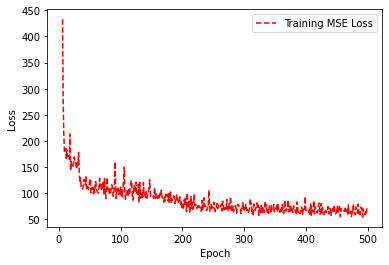

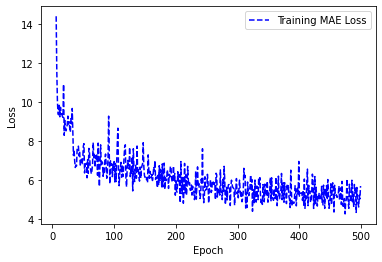

In [13]:
# plotting mse loss
training_mse_loss = model_history.history['loss']
training_mae_loss = model_history.history['mean_absolute_error']

epoch_count = range(6,len(training_mse_loss))

plt.plot(epoch_count, training_mse_loss[6:], 'r--')
plt.legend(['Training MSE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

plt.plot(epoch_count, training_mae_loss[6:], 'b--')
plt.legend(['Training MAE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [14]:
# evaluate on test data
yhat = model.predict(padded_test_X)

# evaluate on train data
yhat_train = model.predict(padded_train_X)

211/211 [==============================] - 2s 10ms/step


test metrics
4.571364841707341
69.95405149294876
0.9934904615078409
train metrics
4.098339456596159
51.43927742633771
0.9950438080140268


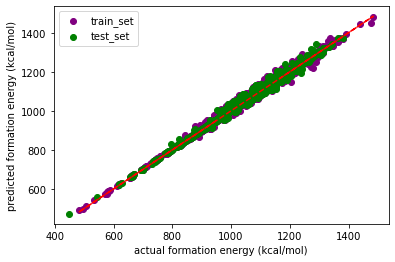

In [15]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat)
mse_test = metrics.mean_squared_error(test_y,yhat)
r2_test = metrics.r2_score(test_y,yhat)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train)
mse_train = metrics.mean_squared_error(train_y,yhat_train)
r2_train = metrics.r2_score(train_y,yhat_train)

print(mae_train)
print(mse_train)
print(r2_train)

plt.scatter(train_y,yhat_train,color = 'purple')
plt.scatter(test_y,yhat, color = 'green')
plt.plot(train_y,train_y, 'r--')
#plt.title('Parity plot')
plt.ylabel('predicted formation energy (kcal/mol)')
plt.xlabel('actual formation energy (kcal/mol)')
plt.legend(['train_set', 'test_set'])
plt.show()

# Saving the trained model

In [16]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

In [17]:
# save the model to disk
filename = 'output/formation_energy/formationenergy_stable_model.h5'
save_model(model, filename)

# Loading the saved model

In [18]:
# load the model from disk
filename = 'output/formation_energy/formationenergy_stable_model.h5'
loaded_model = load_model(filename)

# Testing the saved model

In [19]:
# evaluate on train and test data
yhat_test_loaded = loaded_model.predict(padded_test_X)
yhat_train_loaded = loaded_model.predict(padded_train_X)

211/211 [==============================] - 2s 9ms/step


In [20]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat_test_loaded)
mse_test = metrics.mean_squared_error(test_y,yhat_test_loaded)
r2_test = metrics.r2_score(test_y,yhat_test_loaded)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train_loaded)
mse_train = metrics.mean_squared_error(train_y,yhat_train_loaded)
r2_train = metrics.r2_score(train_y,yhat_train_loaded)

print(mae_train)
print(mse_train)
print(r2_train)

test metrics
4.571364841707341
69.95405149294876
0.9934904615078409
train metrics
4.098339456596159
51.43927742633771
0.9950438080140268


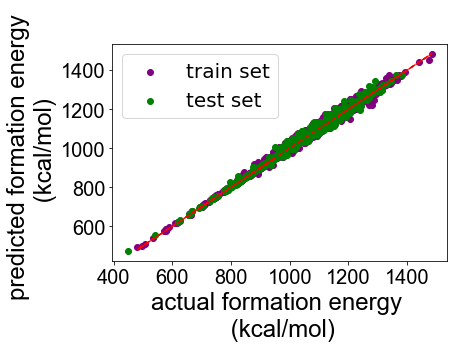

In [21]:
plt.scatter(train_y,yhat_train_loaded,color = 'purple')
plt.scatter(test_y,yhat_test_loaded, color = 'green')
plt.plot(train_y,train_y, 'r--')

plt.ylabel('predicted formation energy \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.xlabel('actual formation energy \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.legend(['train set', 'test set'], fontsize="20" )
plt.xticks(fontsize=20, fontname="Arial")
plt.yticks(fontsize=20, fontname="Arial")
plt.savefig("figures/formation_energy/pp_fe_stable.png", format="png", dpi=1600, bbox_inches='tight')
plt.show()